# Homework 1: Numpy, Scipy, Pandas

### Due Monday Feb 5, 2018 @ 2pm


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="data/screenshot_1.png">

Name your repo something sensible (e.g., python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="data/screenshot_2.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
cd /class/directories ## this will be different on your machine...whereever you want to keep your work.

# change <username> to your github username:
git clone https://github.com/<username>/python-ay250-homework.git
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp -r Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
```

e. To submit your work, go to this form to register your homework Repo URL (https://goo.gl/forms/4DTPxonYBAxmfxJG2). If you've made your repo private, you'll need to add us as collaborators to the repo.  Our Github handles are `@profjsb` and `@chelseaharris`.

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="Data/im2-1.png">

A tarball of the data is at: https://drive.google.com/open?id=0B4vIeCR-xYNnbXFJTTVlVnpUZkk

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint1: you'll need to figure out how to resize a numpy array
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import register_translation
import scipy.misc
import scipy.interpolate

def load_images():
    """
    loads the images from the data files
    
    :returns: list of np arrays, each representing an image
    """
    base = './data/Data/im2-'
    ending = '.png'
    images = []
#     pixels = 288
#     pixels3 = int(pixels*3)
    original = np.arange(288)
    new = np.arange(0,287+1/3,1/3)
    for i in range(100):
        file = ''.join([base,str(i),ending])
        image = scipy.misc.imread(file,flatten=True)
        interp_func = scipy.interpolate.interp2d(original,original,image,kind='linear')
        images.append(interp_func(new,new))
#         wrapper = np.zeros((pixels,pixels3))
#         image = np.hstack([np.zeros((pixels,pixels)),image,np.zeros((pixels,pixels))])
#         image = np.vstack([wrapper,image,wrapper])
#         images.append(image)
    return images

def calc_offset(base,image):
    """
    calculates the offset between the base image and another input image
    
    :base: np array
    :image: np array
    
    :returns: calculates the offsets of image with respect to base
    """
    return np.multiply(register_translation(image,base,100)[0],3)

def return_offsets(images,reference):
    """
    calculates and returns the offsets of each image relative to the
    reference one
    
    :images: list of np arrays representing images
    :reference: integer index representing which image to use as the reference
    
    :returns: list of the pixel offsets for each image relative to the reference
    """
    offsets = [calc_offset(images[reference],images[i]) for i in range(100)]
    return offsets

In [2]:
frames = load_images()
deltas = return_offsets(frames,1)

/home/kceades/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

In [3]:
import scipy.ndimage

def shift_images(images,offsets):
    """
    shifts the frames according to their offsets
    
    :images: list of np arrays representing images
    :offsets: list of np arrays representing row,col shifts
    
    :returns: list of np arrays representing the shifted images
    """
    return_images = []
    for i in range(100):
        return_images.append(scipy.ndimage.interpolation.shift(images[i],offsets[i]))
    return return_images

shifted_frames = shift_images(frames,deltas)

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

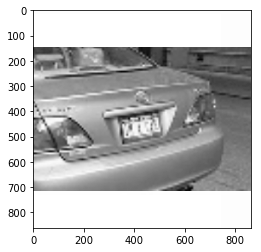

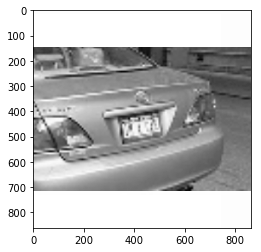

In [4]:
def combine_frames(images):
    """
    combines multiple frames into a single image
    
    :images: list of np arrays representing images
    
    :returns: single np array representing an image
    """
    total = images[0]
    count = 1
    for i in range(1,100):
        total = np.add(total,images[1])
        count += 1
    return np.divide(total,count)

final_image = combine_frames(shifted_frames)

def show_image(image):
    """
    displays an image
    
    :image: np array representing an image
    """
    plt.figure()
    plt.imshow(final_image,cmap='gray')
    plt.show(block=False)
    
show_image(final_image)
show_image(frames[1])

In [ ]:
"""
For some reason, I couldn't quite get the superimaging to work.
I wasn't super clear about how to calculate fractional pixel shifts
when looking for maxima in fourier transforms can only give full
pixel shifts, so I used another scipy related module to calculate
shifts, but it doesn't seem to change when I rescale the array (at
least using linear interpolation, which might be the culprit).
But regardless when I look at the overall image, it isn't any better
that the original.
"""

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [5]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

Populating the interactive namespace from numpy and matplotlib


We define a simple utility function to listen to audio files right in the browser:

In [6]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [7]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `Homeworks/hw1/data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [8]:
Audio('./data/voice.wav')

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [9]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    transformed = np.fft.rfft(x)
    mags = np.abs(transformed)
    low_indices = np.argsort(mags)
    num_freqs = len(transformed)
    largest_kept = int(np.ceil(num_freqs*fraction))
    for i in range(largest_kept):
        transformed[low_indices[i]] = 0
    return np.fft.irfft(transformed)

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [10]:
x = np.random.rand(128)

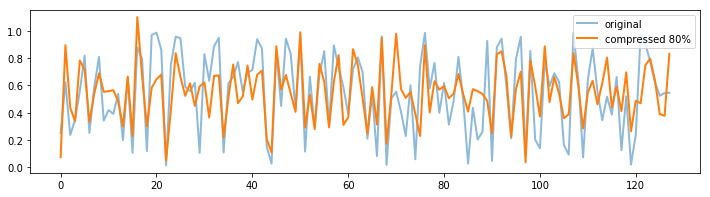

In [11]:
fraction = 0.8  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [12]:
import scipy.io.wavfile

def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    rate,data = scipy.io.wavfile.read(fname)
    data_approx = compress_signal(data,fraction)
    new_fname = './data/voice_{}.wav'.format(int(fraction*100))
    scipy.io.wavfile.write(new_fname,rate,data_approx)
    return rate,data,data_approx,new_fname

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](http://docs.python.org/2/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [13]:
import collections

voices = collections.OrderedDict()
for ratio in [0.1,0.5,0.75,0.9,0.95,0.99]:
    rate,data,data_approx,new_fname = compress_wav('./data/voice.wav',ratio)
    voices[ratio] = (data_approx,new_fname)

**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

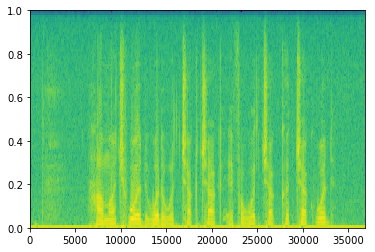

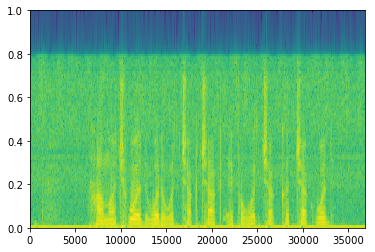

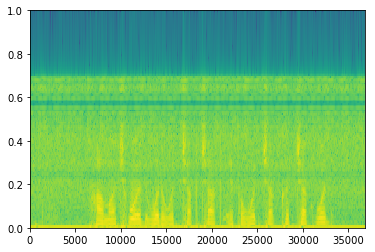

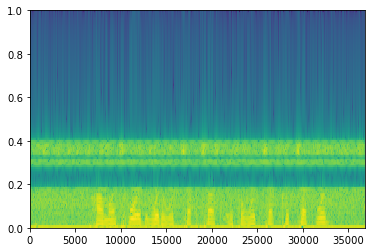

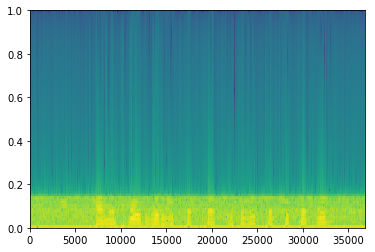

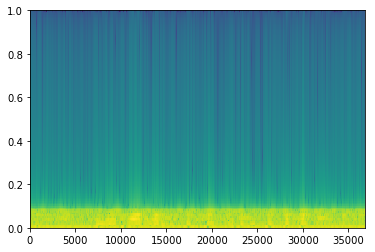

In [14]:
for key in voices:
    Audio(voices[key][1])
    plt.figure()
    plt.specgram(voices[key][0],Fs=2)
    plt.show(block=False)

In [ ]:
"""
From the audio files and spectrograms, I can safely say
that I still understand the recording around a compression ratio of
0.75. At 0.9 and even 0.95, I can understand it pretty well, but 
I'm hesistant to say it would be clear without having heard the
audio already.

Also for some reason the audio player widget doesn't load here when
I'm running through the for loop, so I just listened to the created
files.
"""

# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle` (you'll want to normalize your signal so it has a mean of zero.)

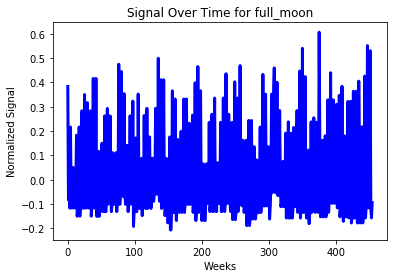

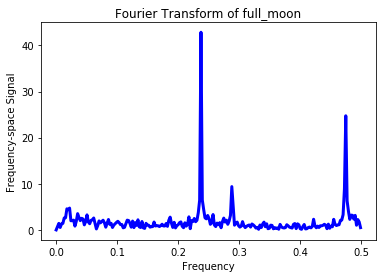

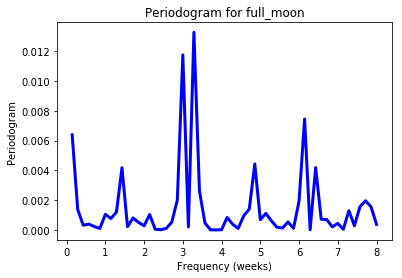

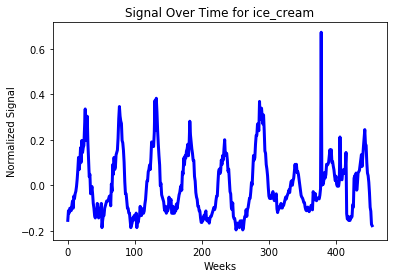

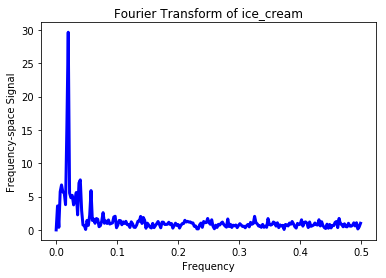

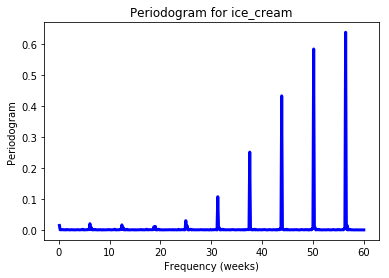

Period of moon calculated from fft: 29 days
Period of moon calculated from periodogram: 23 days
Days in a year calculated from fft: 353 days
Days in a year calculated from periodogram: 395 days


In [15]:
import pandas as pd
import numpy as np
import scipy.signal
from scipy.signal import lombscargle
import matplotlib.pyplot as plt

def calc_period(variable='full_moon',week_cap=8,norm_window=52):
    """
    calculates and returns the period of the moon's orbit in days
    
    :variable: choose from 'full_moon' or 'ice_cream'
    :week_cap: the expected number of weeks (roughly) as an overestimate
                for the result to be contained in
    :norm_window: the window in weeks to have a rolling normalization over
    
    :returns: ints of the moon's orbit in days (calculated two ways)
    """
    raw_data = pd.read_csv('./data/astro.csv')
    data = np.transpose(raw_data.as_matrix(columns=[variable]))[0]
    # normalize over __ week windows
    # note that if I do this, the periodogram answer changes by quite a bit
    # but oddly in a way that seems insensitive to my norm_window
    normalizing = np.zeros(len(data))
    maxes = np.zeros(len(data))
    for i in range(0,len(data),norm_window):
        norm = np.mean([data[x] for x in range(i,min(i+norm_window,len(data)))])
        local_max = np.max([data[x] for x in range(i,min(i+norm_window,len(data)))])
        for j in range(i,min(i+norm_window,len(data))):
            normalizing[j] = norm
            maxes[j] = local_max
    data = np.subtract(data,normalizing)
    data = np.divide(data,maxes)
    plt.figure()
    plt.plot(np.arange(len(data)),data,linewidth=3,color='blue')
    plt.xlabel('Weeks')
    plt.ylabel('Normalized Signal')
    plt.title('Signal Over Time for {}'.format(variable))
    plt.show(block=False)
    
    # looking at the fft
    transformed = np.fft.rfft(data)
    fft_freqs = np.fft.rfftfreq(len(data),d=1)
    mags = np.abs(transformed)
    plt.figure()
    plt.plot(fft_freqs,mags,color='blue',linewidth=3)
    plt.xlabel('Frequency')
    plt.ylabel('Frequency-space Signal')
    plt.title('Fourier Transform of {}'.format(variable))
    plt.show(block=False)
            
    # compute periodogram based on week frequency
    freqs = np.arange(1/7,week_cap+1/7,1/7)
    periodogram = scipy.signal.lombscargle(np.arange(len(data)),data,freqs,precenter=True,normalize=True)
    plt.figure()
    plt.plot(freqs,periodogram,color='blue',linewidth=3)
    plt.xlabel('Frequency (weeks)')
    plt.ylabel('Periodogram')
    plt.title('Periodogram for {}'.format(variable))
    plt.show(block=False)
    # return number of days
    return int(7/fft_freqs[np.argmax(mags)]),int(freqs[np.argmax(periodogram)]*7)

moon_days_fft,moon_days_periodogram = calc_period()
earth_days_fft,earth_days_periodogram = calc_period('ice_cream',60,norm_window=104)
print('Period of moon calculated from fft: {} days'.format(moon_days_fft))
print('Period of moon calculated from periodogram: {} days'.format(moon_days_periodogram))
print('Days in a year calculated from fft: {} days'.format(earth_days_fft))
print('Days in a year calculated from periodogram: {} days'.format(earth_days_periodogram))

# #4: Reproducing some insights about the Election

Nate ("not a genius, just a Bayesian") Silver writes often about polls and their utility of predicting elections. One of the things he emphasized during the 2016 campaign is that even "large" polls of people with a consistent lead for one candidate will show wild swings in any given window in time.

**Problem 1**: Using Pandas and `numpy`, try to reproduce this plot from a Nate Silver Tweet qualitatively using the same assumptions.

<img src="https://www.evernote.com/l/AUU-KkH3Z-lBdKokzCzVIUe53YZLQ9e_AuMB/image.png">

https://twitter.com/NateSilver538/status/769565612955824128

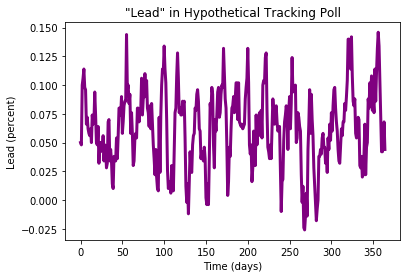

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def create_dailies(lead,num_days=365,poll_per_day=200):
    """
    creates daily poll statistics based on a given point lead (in percent)
    
    :lead: (int or float) lead in percent
    :num_days: (int) number of days to create data for
    :poll_per_day: (int) number of people to poll per day
    
    :returns: np array of leads in the 'tracking poll'
    """
    odds = 0.5-lead/200
    results = []
    days = []
    for i in range(num_days+4):
        for_votes = np.sum(np.where(np.random.rand(poll_per_day)>odds,1,0))
        if len(days)==5:
            days = days[1:] + [for_votes]
        else:
            days.append(for_votes)
        if len(days)==5:
            results.append(2*(np.sum(days)-poll_per_day*5/2)/(poll_per_day*5))
    return np.array(results)

def create_figure(lead,num_days=365,poll_per_day=200):
    """
    actually attempts to recreate the picture from Nate Silver's blog
    (except the month labels on x-axis and gridlines since those
    are really just formatting things, not the data)
    
    :lead: (int or float) lead in percent
    :num_days: (int) number of days to create data for
    :poll_per_day: (int) number of people to poll per day
    """
    results = create_dailies(lead,num_days)
    plt.figure()
    plt.plot(np.arange(num_days),results,color='purple',linewidth=3)
    plt.xlabel('Time (days)')
    plt.ylabel('Lead (percent)')
    plt.title('"Lead" in Hypothetical Tracking Poll')
    plt.show(block=False)
    
create_figure(6)

**Problem 2**: Clearly, even with a 6% point lead, there's a chance that this sort of poll would show the other person in the lead. How much would ahead (in percent) would a candidate need to be to have a tracking poll never show the other candidate to be ahead over the course of a year (in your simulation)?

In [22]:
def min_lead(num_simulations=500):
    """
    determines the minimum lead  in order to have a tracking poll never show the other candidate
    to be ahead over the course of a year; this is determined by running the simulation a number
    of times in steps of lead or number of people until no simulation comes back with the other
    candidate ever leading
    
    :num_simulations: (int) the number of simulations to run before considering it a valid result
    """
    lead = 1
    while lead<1000:
        broke = False
        for i in range(num_simulations):
            results = create_dailies(lead)
            if np.min(results)<0:
                broke = True
                break
        if broke is False:
            break
        lead += 1
    return lead

print('The minimum lead a candidate would need to have a tracking poll never show the other ahead is {} points.'\
      .format(min_lead()))

The minimum lead a candidate would need to have a tracking poll never show the other ahead is 14 points.


**Problem 3**: With a 3 and 6% lead, how many people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead (over a year)?

In [24]:
def min_poll(lead=3,num_simulations=500):
    """
    determines the minimum number of people to be polled per day to have the rolling 5-day poll results
    always show the leader ahead over a year (basically the same simulation as for problem 2)
    
    :lead: (int or float) the lead to use in the simulations
    :num_simulations (int) the number of simulations to run before considering it a valid result
    """
    num_poll = 100
    while num_poll<10000:
        broke = False
        for i in range(num_simulations):
            results = create_dailies(lead,365,num_poll)
            if np.min(results)<0:
                broke = True
                break
        if broke is False:
            break
        num_poll += 100
    return num_poll

print('For a 3 percent lead, {} people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead over a year.'.format(min_poll(3)))
print('For a 6 percent lead, {} people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead over a year.'.format(min_poll(6)))

For a 3 percent lead, 4200 people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead over a year.
For a 6 percent lead, 1100 people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead over a year.
